<a href="https://colab.research.google.com/github/gloxy115/Active-Learning-for-Fake-News-Classification-Using-BERT/blob/main/Experiment_1_Baseline_Models(LR%2C_LSTM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path = '/content/drive/MyDrive/'
import matplotlib.pyplot as plt
%matplotlib inline
import sys
import numpy as np
import pandas as pd
import os
import random
import heapq
import gc
from scipy.spatial import distance_matrix
from IPython import display
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score,classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import layers
from keras.wrappers.scikit_learn import KerasClassifier

In [3]:
!pip install git+https://github.com/modAL-python/modAL.git  #install modAL package

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/modAL-python/modAL.git to /tmp/pip-req-build-_g0yjmnh
  Running command git clone -q https://github.com/modAL-python/modAL.git /tmp/pip-req-build-_g0yjmnh


In [4]:
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling   #randomsampling is not included in the package so is defined as a function later

In [5]:
def set_seed(x):  #setting the seed so the initial result is same for the same model
  seed_value= x
  # 1. Set `PYTHONHASHSEED` environment variable at a fixed value
  os.environ['PYTHONHASHSEED']=str(seed_value)

  # 2. Set `python` built-in pseudo-random generator at a fixed valu
  random.seed(seed_value)

  # 3. Set `numpy` pseudo-random generator at a fixed value

  np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value

  tf.random.set_seed(seed_value)

# 5. Configure a new global `tensorflow` session
  from keras import backend as K

  session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
  sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
  tf.compat.v1.keras.backend.set_session(sess)
  tf.keras.utils.set_random_seed(seed_value)  # sets seeds for base-python, numpy and tf
  tf.config.experimental.enable_op_determinism()


In [6]:
seedn=111

# select a data to have it as a train_data, in this notebook, I ran it for ISOT

In [7]:
#ISOT

train_data = pd.read_csv(path + 'ISOT_may.csv', encoding="ISO-8859-1")


In [8]:
#politifact

#train_data = pd.read_csv(path + 'Politifact_may.csv', encoding="ISO-8859-1")
#train_data.rename({'sentiment':'labels'}, axis=1, inplace=True)

In [9]:
#cc

#train_data = pd.read_csv(path + 'CC_may.csv', encoding="ISO-8859-1")


In [10]:
#kaggle

#train_data = pd.read_csv(path + 'Kaggle_may.csv', encoding="ISO-8859-1")


In [11]:
#covid

#train_data = pd.read_csv(path + 'Covid_may.csv', encoding="ISO-8859-1")


Prep

In [8]:
set_seed(seedn)  #setting the seed 

In [9]:
def trun(data):  #this function truncates the text data so its same length(510) as the input for BERT
    normalized = []
    for i in data:
        i = ' '.join(i.split()[:510])
        normalized.append(i)
    return normalized

In [10]:
TEST_SIZE=0.3 #30% of the dataset is test data

train_data=train_data.dropna()
train_data=train_data[['text','labels']]  
train_data=train_data.drop_duplicates(subset=['text', 'labels'], keep='last')

if len(train_data)>15000:  # if the dataset is more than 15000 instances, randomly select 15000
  train_data = train_data.sample(15000).reset_index(drop=True)

train_data, test_data = train_test_split(train_data, test_size=TEST_SIZE)
train_data = train_data.reset_index(drop=True)

##first 510 words
train_data['text']=trun(train_data['text'])
train_data = train_data.to_dict(orient='records')
test_data = test_data.to_dict(orient='records')
train_texts, train_labels = list(zip(*map(lambda d: (d['text'], d['labels']), train_data)))
test_texts, test_labels = list(zip(*map(lambda d: (d['text'], d['labels']), test_data)))

train_y = np.array(train_labels) == 1
test_y = np.array(test_labels) == 1

Logistic Regression with modAL package

In [11]:
vectorizer = CountVectorizer(ngram_range=(1,3))
e=vectorizer.fit_transform(train_texts)
l=vectorizer.transform(test_texts)

# assemble initial data
n_initial = 100

#stratified initial batch 
idx_False=np.where(train_y == False)[0]
idx_True=np.where(train_y== True)[0]
k=int(len(np.where(train_y == False)[0])/len(train_y)*100) #this is the ratio of the original dataset
    
initial_False=random.sample(idx_False.tolist(),k) 
initial_True=random.sample(idx_True.tolist(),n_initial -k)
    
initial_idx=initial_False+initial_True



X_initial = np.array(train_texts)[initial_idx]
y_initial = np.array(train_labels)[initial_idx]

# generate the pool
# remove the initial data from the training dataset
X_pool = np.delete(train_texts, initial_idx, axis=0)
y_pool = np.delete(train_labels, initial_idx, axis=0)

In [12]:
# initialize ActiveLearner
learner = ActiveLearner(
    estimator=LogisticRegression(),
    X_training=vectorizer.transform(X_initial), y_training=y_initial,
)

# the active learning loop
LR_uncertainty_results = [accuracy_score(test_labels, learner.predict(l))]
n_queries = 5
for idx in range(n_queries):
    print('Query no. %d' % (idx + 1))
    query_idx, query_instance = learner.query(vectorizer.transform(X_pool), n_instances=100)
    learner.teach(
        X=vectorizer.transform(X_pool[query_idx]), y=y_pool[query_idx]
    )
    # remove queried instance from pool
    X_pool = np.delete(X_pool, query_idx, axis=0)
    y_pool = np.delete(y_pool, query_idx, axis=0)
    LR_uncertainty_results.append(accuracy_score(test_labels, learner.predict(l)))

Query no. 1
Query no. 2
Query no. 3
Query no. 4
Query no. 5


In [13]:
LR_uncertainty_results  #Logistic regression + Uncertainty sampling results 

[0.8942222222222223,
 0.9075555555555556,
 0.9571111111111111,
 0.9637777777777777,
 0.9708888888888889,
 0.9724444444444444]

In [14]:
def random_sampling(classifier, X_pool,n_instances):  #defining random sampling
    n_samples = 100
    query_idx = np.random.choice(range(n_samples),size=n_instances)
    return query_idx, X_pool[query_idx]


del learner
# initialize ActiveLearner
learner = ActiveLearner(
    estimator=LogisticRegression(),
    query_strategy=random_sampling,
    X_training=vectorizer.transform(X_initial), y_training=y_initial,
)

# generate the pool
# remove the initial data from the training dataset
X_pool = np.delete(train_texts, initial_idx, axis=0)
y_pool = np.delete(train_labels, initial_idx, axis=0)

# the active learning loop
LR_random_results = [accuracy_score(test_labels, learner.predict(l))]
n_queries = 5
for idx in range(n_queries):
    print('Query no. %d' % (idx + 1))
    query_idx, query_instance = learner.query(vectorizer.transform(X_pool), n_instances=100)
    learner.teach(
        X=vectorizer.transform(X_pool[query_idx]), y=y_pool[query_idx]
    )
    # remove queried instance from pool
    X_pool = np.delete(X_pool, query_idx, axis=0)
    y_pool = np.delete(y_pool, query_idx, axis=0)
    LR_random_results.append(accuracy_score(test_labels, learner.predict(l)))

Query no. 1
Query no. 2
Query no. 3
Query no. 4
Query no. 5


In [15]:
LR_random_results   #Logistic Regression + Random Sampling results

[0.8942222222222223,
 0.9046666666666666,
 0.918,
 0.9242222222222222,
 0.928,
 0.94]

LSTM with modAL package

In [16]:
set_seed(seedn)

In [17]:
#ISOT

train_data = pd.read_csv(path + 'ISOT_may.csv', encoding="ISO-8859-1")


In [18]:
train_data=train_data.dropna()
train_data=train_data[['text','labels']] 
train_data=train_data.drop_duplicates(subset=['text', 'labels'], keep='last')

TEST_SIZE=0.3
if len(train_data)>15000:
  train_data = train_data.sample(15000).reset_index(drop=True)


train_data, test_data = train_test_split(train_data, test_size=TEST_SIZE)
train_data = train_data.reset_index(drop=True)

X_train=train_data['text']
y_train=train_data['labels']
X_test=test_data['text']
y_test=test_data['labels']

vocab_size = 10000
embedding_dim = 64
max_length = 510  
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding=padding_type, truncating=trunc_type, maxlen=max_length)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding=padding_type, truncating=trunc_type, maxlen=max_length)

n_initial = 100

#stratified initial batch 
idx_False=np.where(y_train == 1)[0]
idx_True=np.where(y_train== 0)[0]
k=int(len(np.where(y_train == 1)[0])/len(y_train)*100) #this is the ratio of the original dataset
    
initial_False=random.sample(idx_False.tolist(),k) 
initial_True=random.sample(idx_True.tolist(),n_initial -k)
    
initial_idx=initial_False+initial_True

pool_idx=[x for x in list(np.arange(0,len(X_train))) if (x not in initial_idx)]
pool_idx=np.array(pool_idx)
X_initial = X_train[initial_idx]
y_initial = y_train[initial_idx].to_numpy()









# generate the pool
# remove the initial data from the training dataset
X_pool = np.delete(X_train, initial_idx, axis=0)
y_pool = y_train[pool_idx].to_numpy()


#LSTM model created with Keras package
def keras_LSTM():
    model=Sequential()
    model.add(layers.Embedding(vocab_size, embedding_dim))
    model.add(layers.Bidirectional(layers.LSTM(embedding_dim,  return_sequences=True)))
    model.add(layers.Bidirectional(layers.LSTM(16)))
    model.add(layers.Dense(embedding_dim,activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation="sigmoid"))
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])
    
    print(model.summary())
    return model
keras_lstm=KerasClassifier(keras_LSTM)

def random_sampling(classifier, X_pool,n_instances):
    n_samples = 100
    query_idx = np.random.choice(range(n_samples),size=n_instances)
    return query_idx, X_pool[query_idx]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


In [19]:
# initialize ActiveLearner for random sampling
learner = ActiveLearner(
    estimator=keras_lstm,
    query_strategy=random_sampling,
    X_training=X_initial, y_training=y_initial, epochs=10, shuffle=True, batch_size=16,verbose=2
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          640000    
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        66048     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               18560     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


7/7 - 11s - loss: 0.6928 - accuracy: 0.5300 - 11s/epoch - 2s/step
Epoch 2/10
7/7 - 5s - loss: 0.6922 - accuracy: 0.5500 - 5s/epoch - 751ms/step
Epoch 3/10
7/7 - 5s - loss: 0.6905 - accuracy: 0.5600 - 5s/epoch - 737ms/step
Epoch 4/10
7/7 - 5s - loss: 0.6903 - accuracy: 0.5700 - 5s/epoch - 753ms/step
Epoch 5/10
7/7 - 5s - loss: 0.6874 - accuracy: 0.5800 - 5s/epoch - 757ms/step
Epoch 6/10
7/7 - 5s - loss: 0.6873 - accuracy: 0.6000 - 5s/epoch - 765ms/step
Epoch 7/10
7/7 - 5s - loss: 0.6865 - accuracy: 0.5700 - 5s/epoch - 775ms/step
Epoch 8/10
7/7 - 5s - loss: 0.6887 - accuracy: 0.5500 - 5s/epoch - 710ms/step
Epoch 9/10
7/7 - 5s - loss: 0.6850 - accuracy: 0.5800 - 5s/epoch - 758ms/step
Epoch 10/10
7/7 - 5s - loss: 0.6839 - accuracy: 0.5800 - 5s/epoch - 745ms/step


In [20]:
accuracy_score(y_test.astype(int), learner.predict(X_test).flatten().astype(int))

0.5495555555555556

In [21]:
# the active learning loop

lstm_random_results = [accuracy_score(y_test.astype(int), learner.predict(X_test).flatten().astype(int))]

n_queries = 5
for idx in range(n_queries):
    print('Query no. %d' % (idx + 1))
    query_idx, query_instance = learner.query(X_pool, n_instances=100)
    learner.teach(
        X=X_pool[query_idx], y=y_pool[query_idx], only_new=False,epochs=10, shuffle=True, batch_size=16,verbose=2
    )
    # remove queried instance from pool
    X_pool = np.delete(X_pool, query_idx, axis=0)
    y_pool = np.delete(y_pool, query_idx, axis=0)
    lstm_random_results.append(accuracy_score(y_test.astype(int), learner.predict(X_test).flatten().astype(int)))
del learner

Query no. 1
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 64)          640000    
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 128)        66048     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 32)               18560     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)    

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


13/13 - 16s - loss: 0.6936 - accuracy: 0.4700 - 16s/epoch - 1s/step
Epoch 2/10
13/13 - 10s - loss: 0.6924 - accuracy: 0.5550 - 10s/epoch - 779ms/step
Epoch 3/10
13/13 - 10s - loss: 0.6912 - accuracy: 0.6650 - 10s/epoch - 766ms/step
Epoch 4/10
13/13 - 14s - loss: 0.6907 - accuracy: 0.6600 - 14s/epoch - 1s/step
Epoch 5/10
13/13 - 10s - loss: 0.6884 - accuracy: 0.7500 - 10s/epoch - 761ms/step
Epoch 6/10
13/13 - 10s - loss: 0.6872 - accuracy: 0.7300 - 10s/epoch - 759ms/step
Epoch 7/10
13/13 - 12s - loss: 0.6836 - accuracy: 0.8250 - 12s/epoch - 904ms/step
Epoch 8/10
13/13 - 10s - loss: 0.6790 - accuracy: 0.9000 - 10s/epoch - 748ms/step
Epoch 9/10
13/13 - 9s - loss: 0.6655 - accuracy: 0.9350 - 9s/epoch - 696ms/step
Epoch 10/10
13/13 - 9s - loss: 0.6499 - accuracy: 0.9300 - 9s/epoch - 707ms/step
Query no. 2
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


19/19 - 20s - loss: 0.6929 - accuracy: 0.5400 - 20s/epoch - 1s/step
Epoch 2/10
19/19 - 14s - loss: 0.6916 - accuracy: 0.5567 - 14s/epoch - 715ms/step
Epoch 3/10
19/19 - 14s - loss: 0.6906 - accuracy: 0.5767 - 14s/epoch - 720ms/step
Epoch 4/10
19/19 - 14s - loss: 0.6888 - accuracy: 0.5567 - 14s/epoch - 721ms/step
Epoch 5/10
19/19 - 13s - loss: 0.6833 - accuracy: 0.6800 - 13s/epoch - 692ms/step
Epoch 6/10
19/19 - 13s - loss: 0.6735 - accuracy: 0.7567 - 13s/epoch - 702ms/step
Epoch 7/10
19/19 - 14s - loss: 0.6493 - accuracy: 0.8467 - 14s/epoch - 721ms/step
Epoch 8/10
19/19 - 14s - loss: 0.5539 - accuracy: 0.8867 - 14s/epoch - 735ms/step
Epoch 9/10
19/19 - 13s - loss: 0.4156 - accuracy: 0.9467 - 13s/epoch - 708ms/step
Epoch 10/10
19/19 - 15s - loss: 0.3437 - accuracy: 0.9700 - 15s/epoch - 813ms/step
Query no. 3
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)   

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


25/25 - 20s - loss: 0.6927 - accuracy: 0.5400 - 20s/epoch - 791ms/step
Epoch 2/10
25/25 - 15s - loss: 0.6919 - accuracy: 0.6050 - 15s/epoch - 586ms/step
Epoch 3/10
25/25 - 15s - loss: 0.6910 - accuracy: 0.6200 - 15s/epoch - 585ms/step
Epoch 4/10
25/25 - 15s - loss: 0.6884 - accuracy: 0.6725 - 15s/epoch - 586ms/step
Epoch 5/10
25/25 - 14s - loss: 0.6836 - accuracy: 0.7475 - 14s/epoch - 574ms/step
Epoch 6/10
25/25 - 15s - loss: 0.6719 - accuracy: 0.8675 - 15s/epoch - 589ms/step
Epoch 7/10
25/25 - 14s - loss: 0.6225 - accuracy: 0.8850 - 14s/epoch - 574ms/step
Epoch 8/10
25/25 - 15s - loss: 0.4875 - accuracy: 0.8950 - 15s/epoch - 582ms/step
Epoch 9/10
25/25 - 15s - loss: 0.6039 - accuracy: 0.7700 - 15s/epoch - 593ms/step
Epoch 10/10
25/25 - 15s - loss: 0.5636 - accuracy: 0.7450 - 15s/epoch - 586ms/step
Query no. 4
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


32/32 - 30s - loss: 0.6924 - accuracy: 0.5680 - 30s/epoch - 923ms/step
Epoch 2/10
32/32 - 25s - loss: 0.6902 - accuracy: 0.5860 - 25s/epoch - 766ms/step
Epoch 3/10
32/32 - 25s - loss: 0.6876 - accuracy: 0.6320 - 25s/epoch - 776ms/step
Epoch 4/10
32/32 - 25s - loss: 0.6788 - accuracy: 0.7580 - 25s/epoch - 786ms/step
Epoch 5/10
32/32 - 25s - loss: 0.6251 - accuracy: 0.9100 - 25s/epoch - 785ms/step
Epoch 6/10
32/32 - 25s - loss: 0.4703 - accuracy: 0.8780 - 25s/epoch - 784ms/step
Epoch 7/10
32/32 - 25s - loss: 0.2840 - accuracy: 0.9560 - 25s/epoch - 786ms/step
Epoch 8/10
32/32 - 27s - loss: 0.1982 - accuracy: 0.9700 - 27s/epoch - 839ms/step
Epoch 9/10
32/32 - 25s - loss: 0.1535 - accuracy: 0.9840 - 25s/epoch - 766ms/step
Epoch 10/10
32/32 - 25s - loss: 0.1221 - accuracy: 0.9860 - 25s/epoch - 769ms/step
Query no. 5
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


38/38 - 35s - loss: 0.6927 - accuracy: 0.5450 - 35s/epoch - 921ms/step
Epoch 2/10
38/38 - 29s - loss: 0.6884 - accuracy: 0.6850 - 29s/epoch - 767ms/step
Epoch 3/10
38/38 - 30s - loss: 0.6773 - accuracy: 0.7517 - 30s/epoch - 776ms/step
Epoch 4/10
38/38 - 31s - loss: 0.6091 - accuracy: 0.8750 - 31s/epoch - 817ms/step
Epoch 5/10
38/38 - 28s - loss: 0.4152 - accuracy: 0.9367 - 28s/epoch - 749ms/step
Epoch 6/10
38/38 - 28s - loss: 0.2655 - accuracy: 0.9617 - 28s/epoch - 744ms/step
Epoch 7/10
38/38 - 29s - loss: 0.1697 - accuracy: 0.9850 - 29s/epoch - 767ms/step
Epoch 8/10
38/38 - 29s - loss: 0.1329 - accuracy: 0.9833 - 29s/epoch - 769ms/step
Epoch 9/10
38/38 - 30s - loss: 0.0883 - accuracy: 0.9933 - 30s/epoch - 782ms/step
Epoch 10/10
38/38 - 30s - loss: 0.0628 - accuracy: 0.9983 - 30s/epoch - 778ms/step


In [22]:
lstm_random_results #LSTM with Random Sampling results

[0.5495555555555556,
 0.8204444444444444,
 0.9226666666666666,
 0.8262222222222222,
 0.8844444444444445,
 0.926]

In [23]:
# generate the pool
# remove the initial data from the training dataset
X_pool = np.delete(X_train, initial_idx, axis=0)
y_pool = y_train[pool_idx].values

In [24]:
set_seed(seedn)

In [25]:
# initialize ActiveLearner for uncertainty sampling
learner = ActiveLearner(
    estimator=keras_lstm,
    query_strategy=uncertainty_sampling,
    X_training=X_initial, y_training=y_initial, epochs=10, shuffle=True, batch_size=16,verbose=2
)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 64)          640000    
                                                                 
 bidirectional_12 (Bidirecti  (None, None, 128)        66048     
 onal)                                                           
                                                                 
 bidirectional_13 (Bidirecti  (None, 32)               18560     
 onal)                                                           
                                                                 
 dense_12 (Dense)            (None, 64)                2112      
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 1)                

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


7/7 - 14s - loss: 0.6928 - accuracy: 0.5300 - 14s/epoch - 2s/step
Epoch 2/10
7/7 - 5s - loss: 0.6922 - accuracy: 0.5500 - 5s/epoch - 771ms/step
Epoch 3/10
7/7 - 5s - loss: 0.6905 - accuracy: 0.5600 - 5s/epoch - 772ms/step
Epoch 4/10
7/7 - 5s - loss: 0.6903 - accuracy: 0.5700 - 5s/epoch - 774ms/step
Epoch 5/10
7/7 - 5s - loss: 0.6874 - accuracy: 0.5800 - 5s/epoch - 768ms/step
Epoch 6/10
7/7 - 5s - loss: 0.6873 - accuracy: 0.6000 - 5s/epoch - 774ms/step
Epoch 7/10
7/7 - 5s - loss: 0.6865 - accuracy: 0.5700 - 5s/epoch - 764ms/step
Epoch 8/10
7/7 - 5s - loss: 0.6887 - accuracy: 0.5500 - 5s/epoch - 781ms/step
Epoch 9/10
7/7 - 5s - loss: 0.6850 - accuracy: 0.5800 - 5s/epoch - 776ms/step
Epoch 10/10
7/7 - 5s - loss: 0.6839 - accuracy: 0.5800 - 5s/epoch - 778ms/step


In [26]:
accuracy_score(y_test.astype(int), learner.predict(X_test).flatten().astype(int))

0.5495555555555556

In [27]:
# the active learning loop
lstm_uncertainty_results = [accuracy_score(y_test.astype(int), learner.predict(X_test).flatten().astype(int))]
n_queries = 5
for idx in range(n_queries):
    print('Query no. %d' % (idx + 1))
    query_idx, query_instance = learner.query(X_pool, n_instances=100)
    learner.teach(
        X=X_pool[query_idx], y=y_pool[query_idx], only_new=False,epochs=10, shuffle=True, batch_size=16,verbose=2
    )
    # remove queried instance from pool
    X_pool = np.delete(X_pool, query_idx, axis=0)
    y_pool = np.delete(y_pool, query_idx, axis=0)
    lstm_uncertainty_results.append(accuracy_score(y_test.astype(int), learner.predict(X_test).flatten().astype(int)))

Query no. 1
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, None, 64)          640000    
                                                                 
 bidirectional_14 (Bidirecti  (None, None, 128)        66048     
 onal)                                                           
                                                                 
 bidirectional_15 (Bidirecti  (None, 32)               18560     
 onal)                                                           
                                                                 
 dense_14 (Dense)            (None, 64)                2112      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_15 (Dense)            (None, 1)    

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


13/13 - 19s - loss: 0.6913 - accuracy: 0.6450 - 19s/epoch - 1s/step
Epoch 2/10
13/13 - 11s - loss: 0.6865 - accuracy: 0.6550 - 11s/epoch - 820ms/step
Epoch 3/10
13/13 - 11s - loss: 0.6810 - accuracy: 0.6550 - 11s/epoch - 813ms/step
Epoch 4/10
13/13 - 10s - loss: 0.6708 - accuracy: 0.6550 - 10s/epoch - 803ms/step
Epoch 5/10
13/13 - 11s - loss: 0.6600 - accuracy: 0.6550 - 11s/epoch - 850ms/step
Epoch 6/10
13/13 - 10s - loss: 0.6476 - accuracy: 0.6550 - 10s/epoch - 799ms/step
Epoch 7/10
13/13 - 10s - loss: 0.6287 - accuracy: 0.6550 - 10s/epoch - 798ms/step
Epoch 8/10
13/13 - 10s - loss: 0.6060 - accuracy: 0.6550 - 10s/epoch - 798ms/step
Epoch 9/10
13/13 - 10s - loss: 0.5697 - accuracy: 0.6550 - 10s/epoch - 788ms/step
Epoch 10/10
13/13 - 10s - loss: 0.5291 - accuracy: 0.6550 - 10s/epoch - 794ms/step
Query no. 2
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)   

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


19/19 - 22s - loss: 0.6919 - accuracy: 0.5767 - 22s/epoch - 1s/step
Epoch 2/10
19/19 - 15s - loss: 0.6893 - accuracy: 0.6467 - 15s/epoch - 775ms/step
Epoch 3/10
19/19 - 15s - loss: 0.6839 - accuracy: 0.7133 - 15s/epoch - 777ms/step
Epoch 4/10
19/19 - 15s - loss: 0.6797 - accuracy: 0.7233 - 15s/epoch - 770ms/step
Epoch 5/10
19/19 - 15s - loss: 0.6700 - accuracy: 0.7233 - 15s/epoch - 765ms/step
Epoch 6/10
19/19 - 15s - loss: 0.6517 - accuracy: 0.7567 - 15s/epoch - 765ms/step
Epoch 7/10
19/19 - 15s - loss: 0.6088 - accuracy: 0.7700 - 15s/epoch - 767ms/step
Epoch 8/10
19/19 - 15s - loss: 0.5456 - accuracy: 0.8167 - 15s/epoch - 771ms/step
Epoch 9/10
19/19 - 15s - loss: 0.4782 - accuracy: 0.8600 - 15s/epoch - 776ms/step
Epoch 10/10
19/19 - 15s - loss: 0.3894 - accuracy: 0.9133 - 15s/epoch - 776ms/step
Query no. 3
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)   

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


25/25 - 22s - loss: 0.6924 - accuracy: 0.5725 - 22s/epoch - 897ms/step
Epoch 2/10
25/25 - 16s - loss: 0.6911 - accuracy: 0.6275 - 16s/epoch - 647ms/step
Epoch 3/10
25/25 - 16s - loss: 0.6888 - accuracy: 0.6725 - 16s/epoch - 646ms/step
Epoch 4/10
25/25 - 16s - loss: 0.6837 - accuracy: 0.7675 - 16s/epoch - 652ms/step
Epoch 5/10
25/25 - 16s - loss: 0.6686 - accuracy: 0.8350 - 16s/epoch - 649ms/step
Epoch 6/10
25/25 - 16s - loss: 0.6239 - accuracy: 0.8650 - 16s/epoch - 634ms/step
Epoch 7/10
25/25 - 16s - loss: 0.5499 - accuracy: 0.9000 - 16s/epoch - 637ms/step
Epoch 8/10
25/25 - 16s - loss: 0.3907 - accuracy: 0.9275 - 16s/epoch - 638ms/step
Epoch 9/10
25/25 - 16s - loss: 0.2412 - accuracy: 0.9775 - 16s/epoch - 639ms/step
Epoch 10/10
25/25 - 16s - loss: 0.1865 - accuracy: 0.9850 - 16s/epoch - 633ms/step
Query no. 4
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embeddin

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


32/32 - 32s - loss: 0.6925 - accuracy: 0.5160 - 32s/epoch - 994ms/step
Epoch 2/10
32/32 - 24s - loss: 0.6904 - accuracy: 0.6080 - 24s/epoch - 764ms/step
Epoch 3/10
32/32 - 24s - loss: 0.6864 - accuracy: 0.6980 - 24s/epoch - 751ms/step
Epoch 4/10
32/32 - 24s - loss: 0.6728 - accuracy: 0.7880 - 24s/epoch - 748ms/step
Epoch 5/10
32/32 - 25s - loss: 0.6276 - accuracy: 0.8280 - 25s/epoch - 767ms/step
Epoch 6/10
32/32 - 25s - loss: 0.5369 - accuracy: 0.8940 - 25s/epoch - 770ms/step
Epoch 7/10
32/32 - 23s - loss: 0.3291 - accuracy: 0.9360 - 23s/epoch - 713ms/step
Epoch 8/10
32/32 - 23s - loss: 0.1778 - accuracy: 0.9760 - 23s/epoch - 728ms/step
Epoch 9/10
32/32 - 24s - loss: 0.1166 - accuracy: 0.9940 - 24s/epoch - 763ms/step
Epoch 10/10
32/32 - 24s - loss: 0.0798 - accuracy: 0.9940 - 24s/epoch - 741ms/step
Query no. 5
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embeddin

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


38/38 - 34s - loss: 0.6919 - accuracy: 0.5550 - 34s/epoch - 896ms/step
Epoch 2/10
38/38 - 29s - loss: 0.6875 - accuracy: 0.5733 - 29s/epoch - 764ms/step
Epoch 3/10
38/38 - 29s - loss: 0.6787 - accuracy: 0.5700 - 29s/epoch - 756ms/step
Epoch 4/10
38/38 - 29s - loss: 0.6481 - accuracy: 0.5950 - 29s/epoch - 764ms/step
Epoch 5/10
38/38 - 29s - loss: 0.5563 - accuracy: 0.8333 - 29s/epoch - 762ms/step
Epoch 6/10
38/38 - 29s - loss: 0.3859 - accuracy: 0.9367 - 29s/epoch - 775ms/step
Epoch 7/10
38/38 - 29s - loss: 0.2165 - accuracy: 0.9733 - 29s/epoch - 768ms/step
Epoch 8/10
38/38 - 30s - loss: 0.1349 - accuracy: 0.9900 - 30s/epoch - 785ms/step
Epoch 9/10
38/38 - 29s - loss: 0.0910 - accuracy: 0.9933 - 29s/epoch - 765ms/step
Epoch 10/10
38/38 - 29s - loss: 0.0662 - accuracy: 0.9983 - 29s/epoch - 769ms/step


In [28]:
lstm_uncertainty_results #LSTM with uncertainty sampling

[0.5495555555555556,
 0.45311111111111113,
 0.8364444444444444,
 0.9115555555555556,
 0.9106666666666666,
 0.944]

These results are then saved, run 5 times and then averaged to make the final graphs for the paper

In [29]:
lst = [['lr_random']+ LR_random_results, 
       ['lr_uncertainty']+LR_uncertainty_results,
      ['lstm_random']+lstm_random_results,
      ['lstm_uncertainty']+lstm_uncertainty_results]
df_results = pd.DataFrame(lst, columns =['AL',100,200,300,400,500,600], dtype = float)


#df_results.to_csv('iost_accuracy_111.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: Could not cast to float64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised
  exec(code_obj, self.user_global_ns, self.user_ns)


In [30]:
df_results

,AL,100,200,300,400,500,600
0,lr_random,0.894222,0.904667,0.918000,0.924222,0.928000,0.940000
1,lr_uncertainty,0.894222,0.907556,0.957111,0.963778,0.970889,0.972444
2,lstm_random,0.549556,0.820444,0.922667,0.826222,0.884444,0.926000
3,lstm_uncertainty,0.549556,0.453111,0.836444,0.911556,0.910667,0.944000


Draw graphs- an example of a graph for baseline models only. 

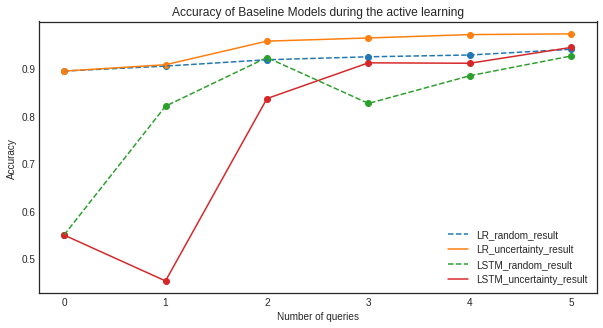

In [31]:
#######################Graph for the baseline model results

len_num=len(LR_random_results)
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(10, 5))
    plt.title('Accuracy of Baseline Models during the active learning')
    plt.plot(np.arange(len_num), LR_random_results, label="LR_random_result",linestyle='dashed')
    plt.scatter(np.arange(len_num), LR_random_results)
    plt.plot(np.arange(len_num), LR_uncertainty_results, label="LR_uncertainty_result")
    plt.scatter(np.arange(len_num), LR_uncertainty_results)
    plt.plot(np.arange(len_num), lstm_random_results, label="LSTM_random_result",linestyle='dashed')
    plt.scatter(np.arange(len_num), lstm_random_results)
    plt.plot(np.arange(len_num), lstm_uncertainty_results, label="LSTM_uncertainty_result")
    plt.scatter(np.arange(len_num), lstm_uncertainty_results)
    plt.xlabel('Number of queries')
    plt.ylabel('Accuracy')
    plt.legend(loc="lower right")
    plt.xticks(range(0,len_num))
    plt.show()